# Adversarial Attacks

In [3]:
!pip install adversarial-robustness-toolbox

     ---------------------------------------- 1.7/1.7 MB 13.1 MB/s eta 0:00:00


In [4]:
#Importing dependencies
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
#Import adversarial-robustness-toolbox as art
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

In [6]:
#Increasing matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [9]:
#Loading data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

# Training a TensorFlow keras model

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D

def create_model():
    #Defining the model
    model = Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=10, activation="softmax")
    ])
    #Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )
    #Returning the model
    return model
    
#Instantiating the model
model = create_model()

#Training the model
model.fit(
     x=train_images,
     y=train_labels,
     epochs=10,
     batch_size=256)


Epoch 1/10
235/235 [==============================] - 15s 63ms/step - loss: 0.2967 - accuracy: 0.9178
Epoch 2/10
235/235 [==============================] - 14s 61ms/step - loss: 0.0693 - accuracy: 0.9790
Epoch 3/10
235/235 [==============================] - 15s 62ms/step - loss: 0.0488 - accuracy: 0.9849
Epoch 4/10
235/235 [==============================] - 15s 64ms/step - loss: 0.0393 - accuracy: 0.9873
Epoch 5/10
235/235 [==============================] - 19s 79ms/step - loss: 0.0312 - accuracy: 0.9907
Epoch 6/10
235/235 [==============================] - 15s 63ms/step - loss: 0.0265 - accuracy: 0.9918
Epoch 7/10
235/235 [==============================] - 17s 71ms/step - loss: 0.0221 - accuracy: 0.9931
Epoch 8/10
235/235 [==============================] - 17s 71ms/step - loss: 0.0174 - accuracy: 0.9946
Epoch 9/10
235/235 [==============================] - 17s 73ms/step - loss: 0.0156 - accuracy: 0.9949
Epoch 10/10
235/235 [==============================] - 16s 67ms/step - loss: 0.012

# Defining an evasion attack on our model

In [29]:
#Creating a classifier by wrapping our tf model in ART's KerasClassifier class
#Create ART classifier object
loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=loss_object,)

In [30]:
#Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
     estimator=classifier,
     eps=0.3
     )

In [31]:
#Generating adversarial images for test images
test_images_adv = attack_fgsm.generate(x=test_images)

# Evaluating the effectiveness of the attack 

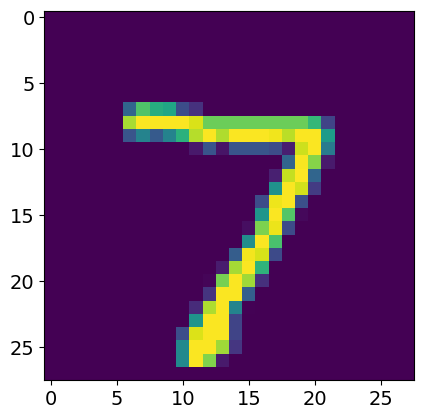

In [32]:
plt.imshow(test_images[0].squeeze())

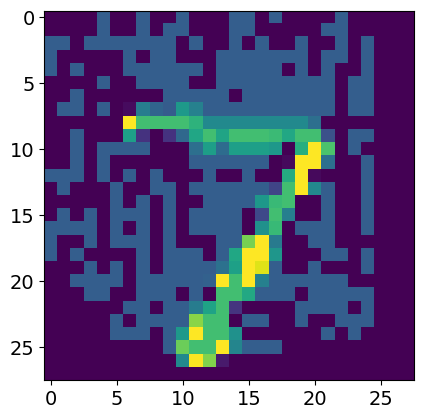

In [33]:
#Viewing an adversarial image
plt.imshow(test_images_adv[0].squeeze())

In [34]:
#Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images,
    y=test_labels
    )

313/313 [==============================] - 2s 5ms/step - loss: 0.0300 - accuracy: 0.9901


In [35]:
#Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv,
    y=test_labels
)

313/313 [==============================] - 1s 5ms/step - loss: 5.2125 - accuracy: 0.1649


In [36]:
#Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f}"
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

Clean test set loss: 0.03vs adversarial set test loss: 5.21


In [37]:
#Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f}"
      f"vs adversarial set test loss: {score_adv[1]:.2f}")

Clean test set accuracy: 0.99vs adversarial set test loss: 0.16


1/1 [==============================] - 0s 21ms/step


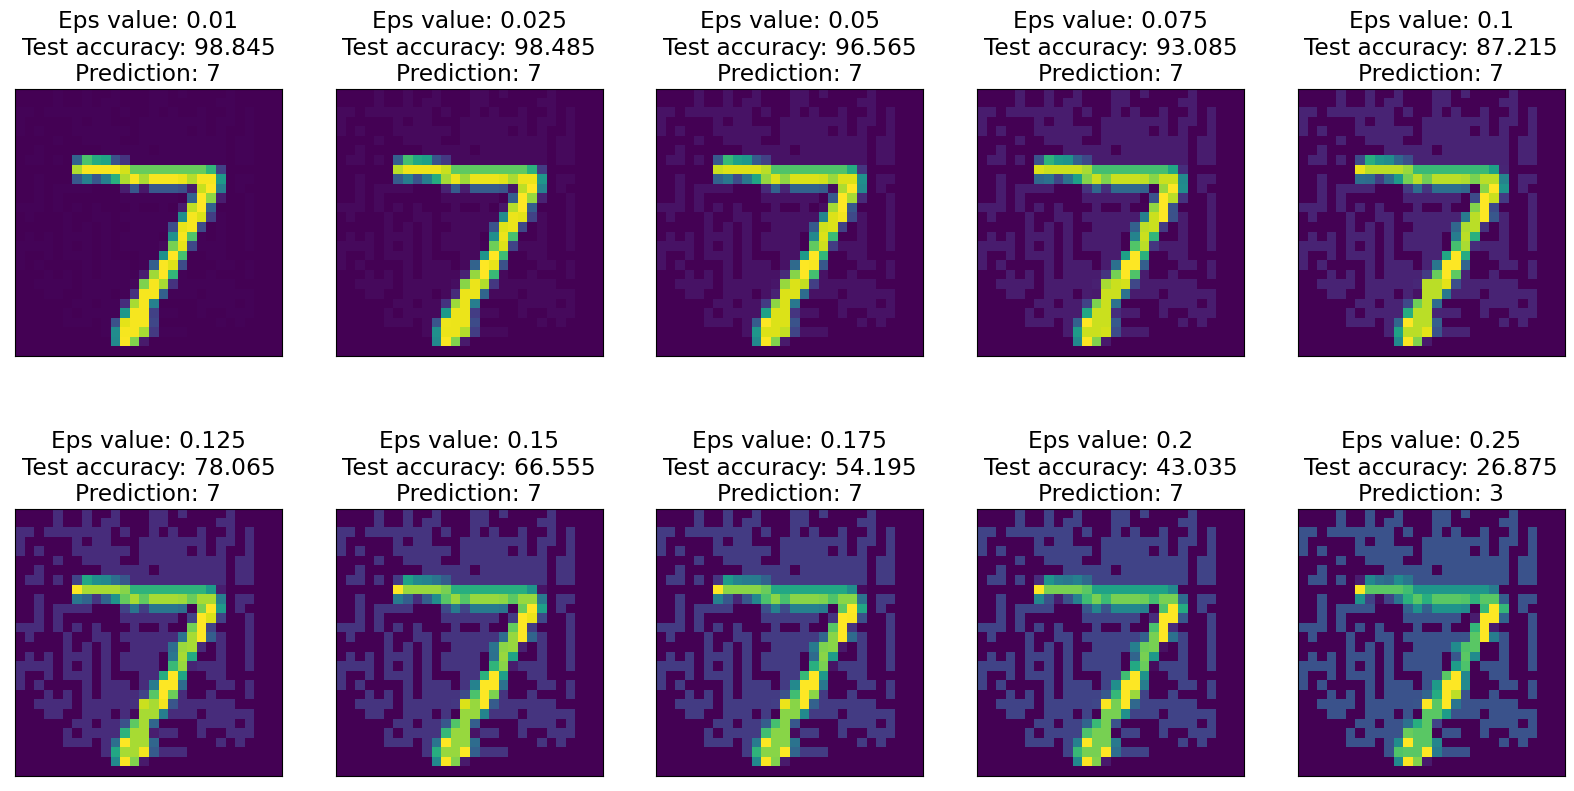

In [45]:
#Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

#Generating subplots
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20,10)
    )

#Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]


#Defining a counting variable to traverse eps_to_try
counter = 0

#Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):
        #Creating an attack object for the current value of eps
        attack_fgsm = FastGradientMethod(
              estimator=classifier,
              eps=eps_to_try[counter]
              )
        #Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)
        
        #Showing the first adversarial images
        axes[i, j].imshow(X=test_images_adv[0].squeeze())
        
        #Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        
        #Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels
            )[1]
        
        #Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0],
            axis=0)
            ))
        
        #Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
        label=f"Eps value: {eps_to_try[counter]}\n"
              f"Test accuracy: {test_score * 100:.2f}5\n"
              f"Prediction: {prediction}"
              )    
        #Incrementing counter
        counter += 1
        
#Showing the plot
plt.show()
        